In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.correction import RoomAreas

%matplotlib inline

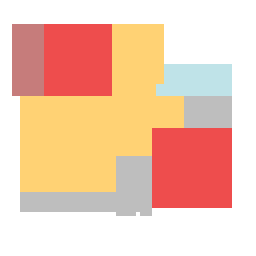

<PlanMasks 137104787303680>

In [4]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [5]:
%%time

min_area_units = 10
rooms = []
for i, node in enumerate(pm.graph.nodes):
    if not NodeType.is_room(node):
        continue

    room = RoomAreas(node, pm.masks[i])
    room.threshold_rectangles(min_area_units)
    room.discard_small_components()
    rooms.append(room)

CPU times: user 1.42 s, sys: 12.6 ms, total: 1.44 s
Wall time: 1.45 s


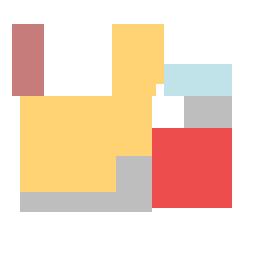

In [6]:
blit_rooms(rooms)

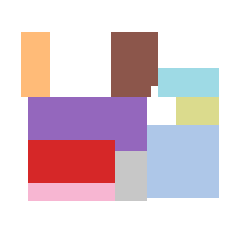

In [10]:
room_index_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
room_index_mask.shape

plt.figure(figsize=(3,3))
cmap = ListedColormap(['white', *plt.get_cmap('tab20').colors])
plt.axis("off")
plt.imshow(room_index_mask, cmap=cmap)

In [14]:
# plt.imshow(rooms[3].to_mask())

r1 = rooms[2].to_mask()
r2 = rooms[3].to_mask()

In [39]:
e_top = down((up(r1) + r2 == 2).byte())
e_bottom = up((down(r1) + r2 == 2).byte())

e_left = right((left(r1) + r2 == 2).byte())
e_right = left((right(r1) + r2 == 2).byte())

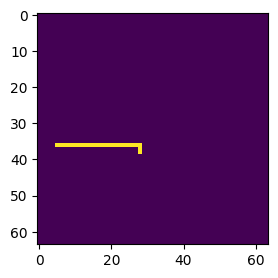

In [45]:
plt.figure(figsize=(3,3))
plt.imshow((e_top + e_right + e_left + e_bottom).clamp_(0,1))

In [33]:
def up(m):
    """Shifts a 2D mask `m` up"""
    top, rest = m[:1, :], m[1:, :]
    return torch.cat([rest, top], dim=0)

def down(m):
    """Shifts a 2D mask `m` down"""
    rest, bottom = m[:-1, :], m[-1:, :]
    return torch.cat([bottom, rest], dim=0)

def left(m):
    """Shifts a 2D mask `m` left"""
    first, rest = m[:, :1], m[:, 1:]
    return torch.cat([rest, first], dim=1)

def right(m):
    """Shifts a 2D mask `m` down"""
    rest, last = m[:, :-1], m[:, -1:]
    return torch.cat([last, rest], dim=1)